# VisualValidationCLIP

In this notebook we seek to assess in a qualitative way the goodness of a
model trained on a CLIP-like fashion. In other words, we want to be sure
that the model is somehow learning to retrieve the right material from both \
    visual and textual branches.

In [1]:
import numpy
import pandas
import torch
import random

from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from data_preprocess.datasets import CLIPDataset
from neural_models.transformers import CLIP

SEED = 1234
torch.backends.cudnn.deterministic = True
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
numpy.random.seed(SEED)

## 1. Retrieve the dataset

In [4]:
DEVICE = "cpu"
device = torch.device(DEVICE)

nb_paintings = 1000
BS = 32
TEXT_COL = "DESCRIPTION"
DATASET_PATH = "../semart.csv"
dataset = pandas.read_csv(DATASET_PATH)[:nb_paintings]
data = CLIPDataset(data=dataset, text_col=TEXT_COL, image_col="localpath")
dataset

IMAGE_FILE                                        DESCRIPTION  \
0    20586-gardenfi.jpg  this f&#234;te galante is set in a formal gard...   
1     09107-marine2.jpg  it has been suggested that this painting shows...   
2    12543-1adameve.jpg  the subject of adam and eve offered durer the ...   
3    05316-10centre.jpg  the central panel of the triptych represents t...   
4     05599-12agony.jpg  this is the only one of botticelli's paintings...   
..                  ...                                                ...   
123   00248-visitat.jpg  mariotto albertinelli, the pupil of cosimo ros...   
124  16988-nuenen03.jpg  catalogue numbers: f 30, jh 479. in nuenen bet...   
125  37850-winterla.jpg  the scene in this snow-covered panoramic lands...   
126  02840-winter_s.jpg  avercamp spent most of his life in the small q...   
127   38636-btoilet.jpg  this painting is the first known example by te...   

                       AUTHOR                                      TITLE  \
0    JANNECK, Franz Christoph       A Palace Garden with Elegant Figures   
1    CLEVELEY, John the Elder  Action off Cape Francois, 21 October 1757   
2             DURER, Albrecht                               Adam and Eve   
3           BOSCH, Hieronymus      Adoration of the Magi (central panel)   
4          BOTTICELLI, Sandro                        Agony in the Garden   
..                        ...                                        ...   
123    ALBERTINELLI, Mariotto                                 Visitation   
124         GOGH, Vincent van                Weaver, Seen from the Front   
125     STALBEMT, Adriaan van                                     Winter   
126        AVERCAMP, Hendrick                    Winter Scene on a Canal   
127          TERBORCH, Gerard      Young Woman at Her Toilet with a Maid   

                                  TECHNIQUE              DATE       TYPE  \
0                 Oil on copper, 41 x 59 cm                 -      genre   
1                 Oil on canvas, 33 x 49 cm                 -  landscape   
2    Oil on panel, 209 x 81 cm (each panel)              1507  religious   
3                  Oil on wood, 138 x 72 cm           c. 1510  religious   
4              Tempera on panel, 53 x 35 cm           c. 1500  religious   
..                                      ...               ...        ...   
123               Oil on wood, 232 x 146 cm              1503  religious   
124               Oil on canvas, 70 x 85 cm  May 1884, Nuenen      other   
125                Oil on panel, 32 x 48 cm                 -  landscape   
126                             Oil on wood                 -  landscape   
127                 Oil on wood, 48 x 35 cm           1650-51      genre   

            SCHOOL  TIMEFRAME  split  \
0         Austrian  1701-1750    val   
1          English  1701-1750    val   
2           German  1501-1550    val   
3    Netherlandish  1451-1500    val   
4          Italian  1451-1500    val   
..             ...        ...    ...   
123        Italian  1451-1500    val   
124          Dutch  1851-1900  train   
125        Flemish  1601-1650    val   
126          Dutch  1601-1650    val   
127          Dutch  1651-1700    val   

                                             localpath  
0    /Users/ricardokleinlein/Desktop/semart/20586-g...  
1    /Users/ricardokleinlein/Desktop/semart/09107-m...  
2    /Users/ricardokleinlein/Desktop/semart/12543-1...  
3    /Users/ricardokleinlein/Desktop/semart/05316-1...  
4    /Users/ricardokleinlein/Desktop/semart/05599-1...  
..                                                 ...  
123  /Users/ricardokleinlein/Desktop/semart/00248-v...  
124  /Users/ricardokleinlein/Desktop/semart/16988-n...  
125  /Users/ricardokleinlein/Desktop/semart/37850-w...  
126  /Users/ricardokleinlein/Desktop/semart/02840-w...  
127  /Users/ricardokleinlein/Desktop/semart/38636-b...  

[128 rows x 11 columns]

## 2. Custom model

In [5]:
MODEL_PATH = "/Users/ricardokleinlein/Desktop/runs/Jan2-15_54-pgth07/" \
             "model_state_dict.pt"
model = CLIP(output_embed=True)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE), strict=True)
model.eval()

dataloader = data.load(batch_size=BS)

sentences = []
visual_embeddings = []
image_paths = []
textual_embeddings = []
label_ids = []

with torch.no_grad():
    for b, batch in enumerate(tqdm(dataloader)):
        batch_inputs, batch_label = batch
        batch_idxs = list(batch_label.cpu().numpy())
        label_ids.extend(batch_idxs)
        image_paths.extend(numpy.array(data.image_paths)[batch_idxs])
        sentences.extend(numpy.array(data.captions)[batch_idxs])

        if isinstance(batch_inputs, list):
            batch_inputs = [
                {k: val.to(device) for k, val in x.items()}
                for x in batch_inputs
            ]
        output = model(batch_inputs).detach().cpu().numpy()
        visual_embeddings.extend(output[0])
        textual_embeddings.extend(output[1])
visual_embeddings = numpy.array(visual_embeddings)
textual_embeddings = numpy.array(textual_embeddings)
model_preds = visual_embeddings @ textual_embeddings.T

100%|██████████| 21/21 [04:13<00:00, 12.08s/it]


## 3. Default CLIP - Does it fail?

In [11]:
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
default_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
default_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

default_texts_embeds = []
default_vision_embeds = []
for b, (sent, img_path) in tqdm(enumerate(zip(sentences, image_paths)),
                                total=len(sentences)):
    image = Image.open(img_path).convert("RGB")
    inputs = default_processor(text=[sent], images=image,
                               return_tensors='pt', padding='max_length',
                               truncation=True)
    outputs = default_model(**inputs)
    default_texts_embeds.append(
        outputs.text_embeds.squeeze().detach().cpu().numpy())
    default_vision_embeds.append(
        outputs.image_embeds.squeeze().detach().cpu().numpy())
default_texts_embeds = numpy.array(default_texts_embeds)
default_vision_embeds = numpy.array(default_vision_embeds)

default_preds = default_vision_embeds @ default_texts_embeds.T

100%|██████████| 672/672 [05:05<00:00,  2.20it/s]


## 4. Compare default and custom CLIP

In [12]:
N = 100
selected = numpy.random.randint(low=0, high=len(image_paths), size=N)
to_display = numpy.random.choice(selected, size=5)

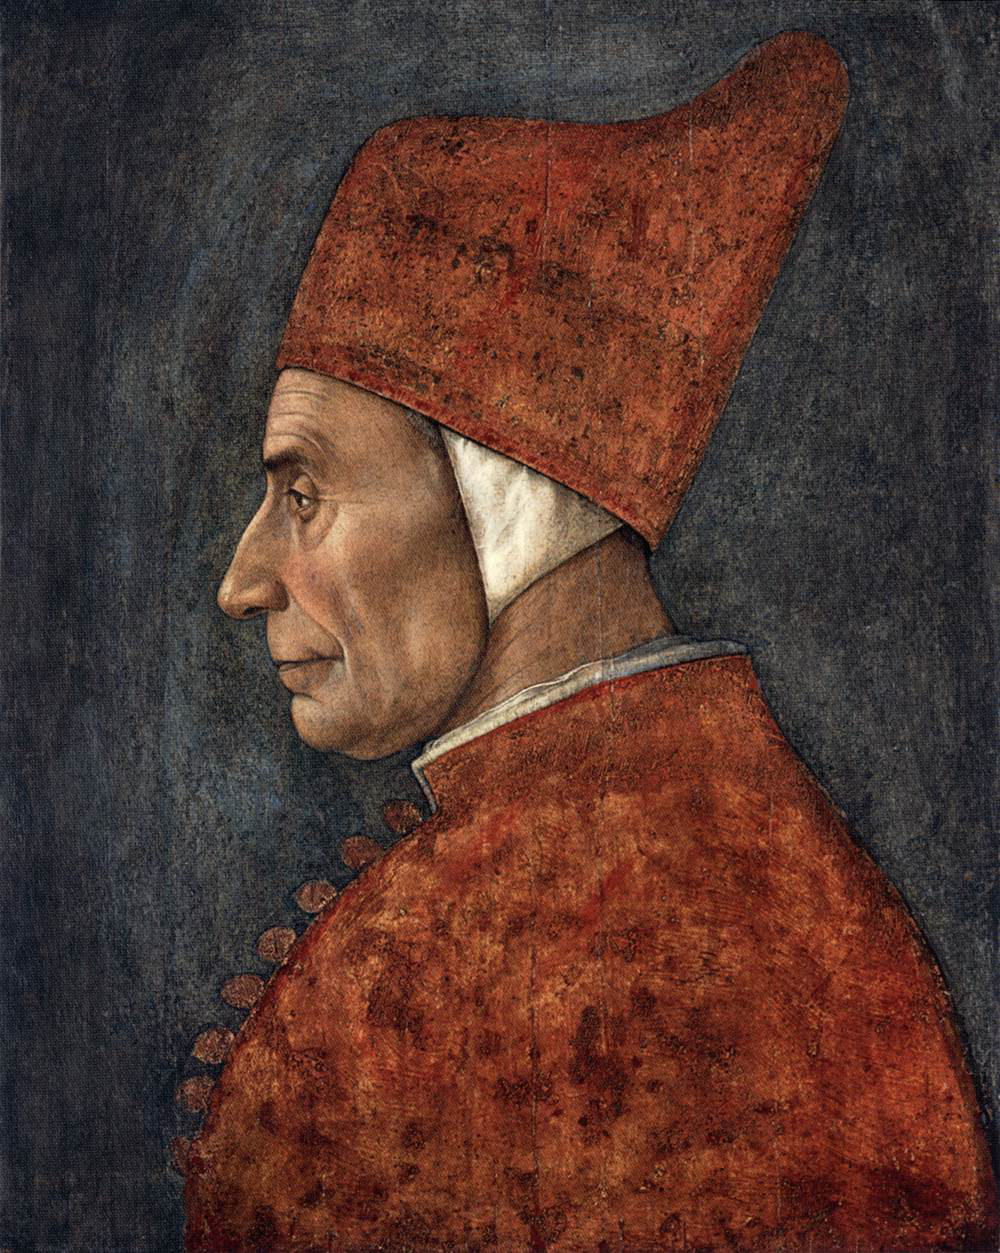

CC:
gentile bellini was the most important portraitist in venice until the 1490s. five portraits of doges by him survived. between about 1460 and 1500 he was charged with creating the official portrait of each of the doges, from pasquale malipiero (1392-1462) to leonardo loredan (1436-1521)the present portrait, the sitter of which can be identified as pasquale malipiero, belongs to gentile's early works. pasquale malipiero was elected doge in 1457, at the age of sixty-five, and held the office until his death. it is assumed that the portrait was produced during his reign, about 1460. bellini, gentile, portrait of a doge, tempera on poplar panel, 53 x 43 cm, portrait, 1451-1500, italian.

Default:
between about 1460 and 1500 he was charged with creating the official portrait of each of the doges, from pasquale malipiero (1392-1462) to leonardo loredan (1436-1521)the present portrait, the sitter of which can be identified as pasquale malipiero, belongs to gentile's early works.
In CC? Tr

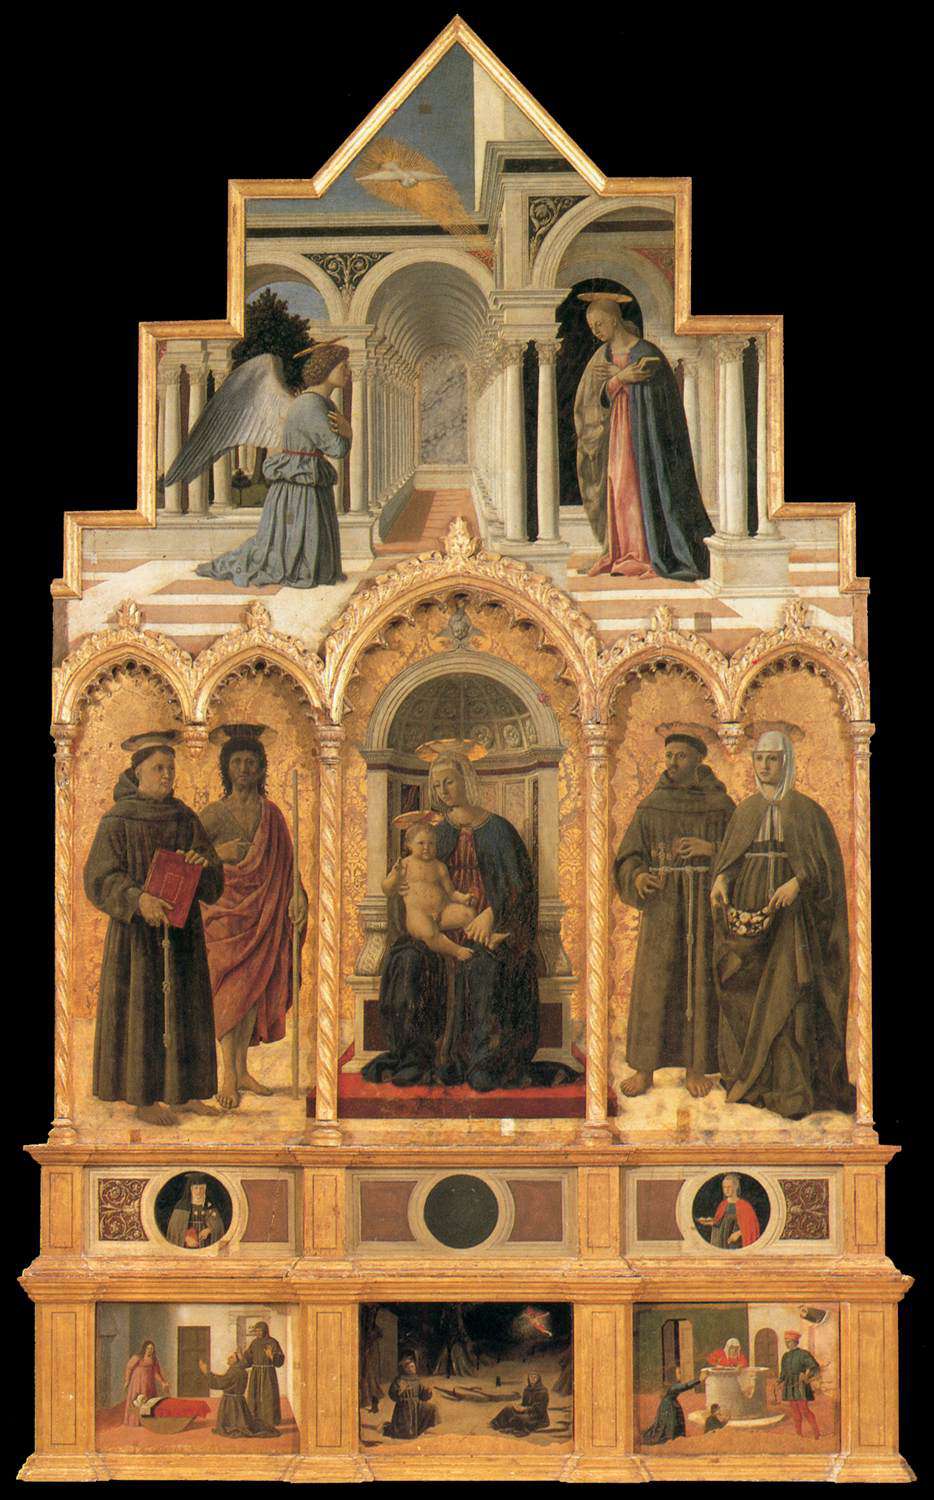

CC:
among the many works that, according to vasari, piero painted in perugia, the historian describes with great admiration the polyptych commissioned by the nuns of the convent of sant'antonio da padova. this complex painting, today in the galleria nazionale dell'umbria in perugia, was begun shortly after piero's return from rome, but was not completed for several years. the central part of the composition, the madonna and child with saints anthony, john the baptist, francis and elizabeth, reveals in its unusual damask-like background the artist's acquaintance with a trend of contemporary spanish painting, which piero would have had the opportunity to see in rome. the polyptych is also made up of three predella panels showing st anthony of padua resurrecting a child, the stigmatisation of st francis and st elizabeth saving a boy who had fallen down a well, as well as two roundels placed between the main panel and the predella. the quality of this predella is extraordinary: piero's cha

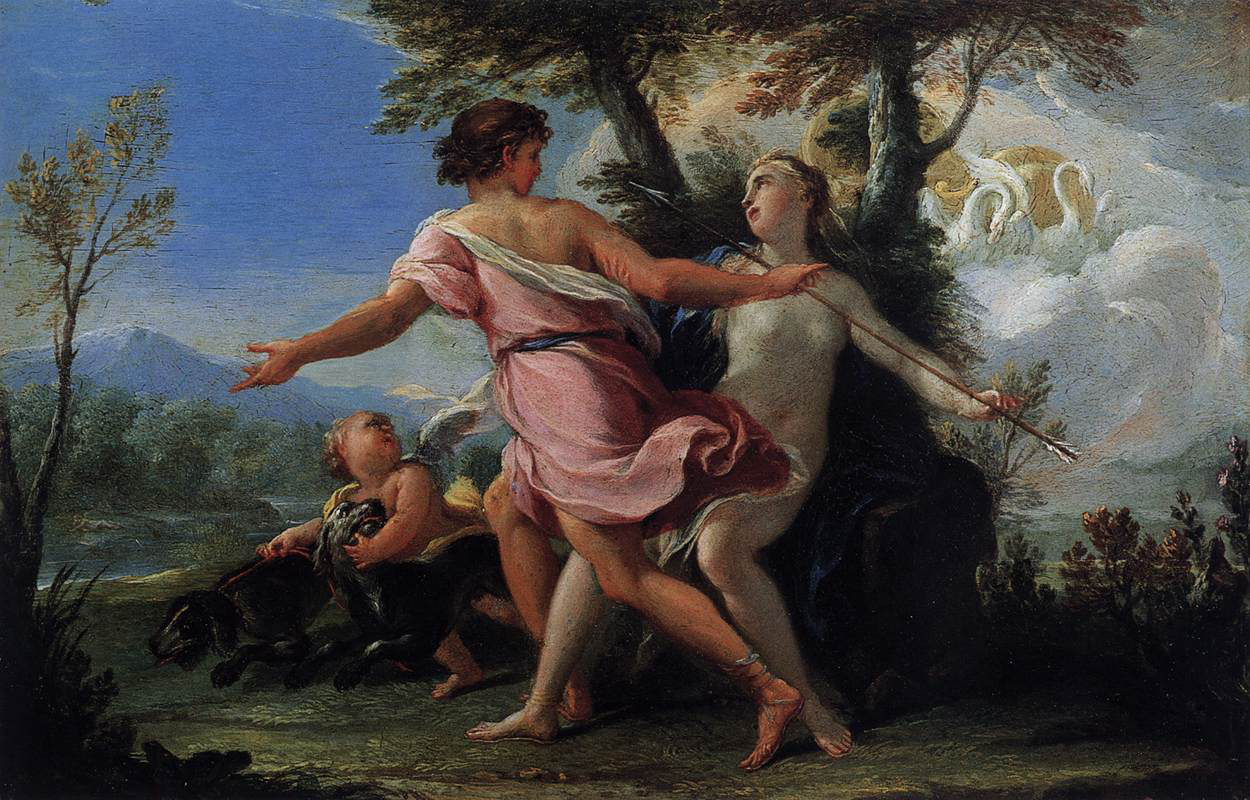

CC:
lauri's speciality was the ideal landscape with mythological subjects into which he introduced stylistic elements from francesco albani, pier francesco mola and gaspard dughet. he painted small-scale arcadian idylls executed with open brushwork in a light colour scheme. the present painting, belonging to a series of six copper panels, is a characteristic example. lauri, filippo, venus and adonis, oil on copper, 18 x 29 cm, mythological, 1651-1700, italian.

Default:
lauri, filippo, venus and adonis, oil on copper, 18 x 29 cm, mythological, 1651-1700, italian.
In CC? True
Custom:
he painted small-scale arcadian idylls executed with open brushwork in a light colour scheme.
In CC? True


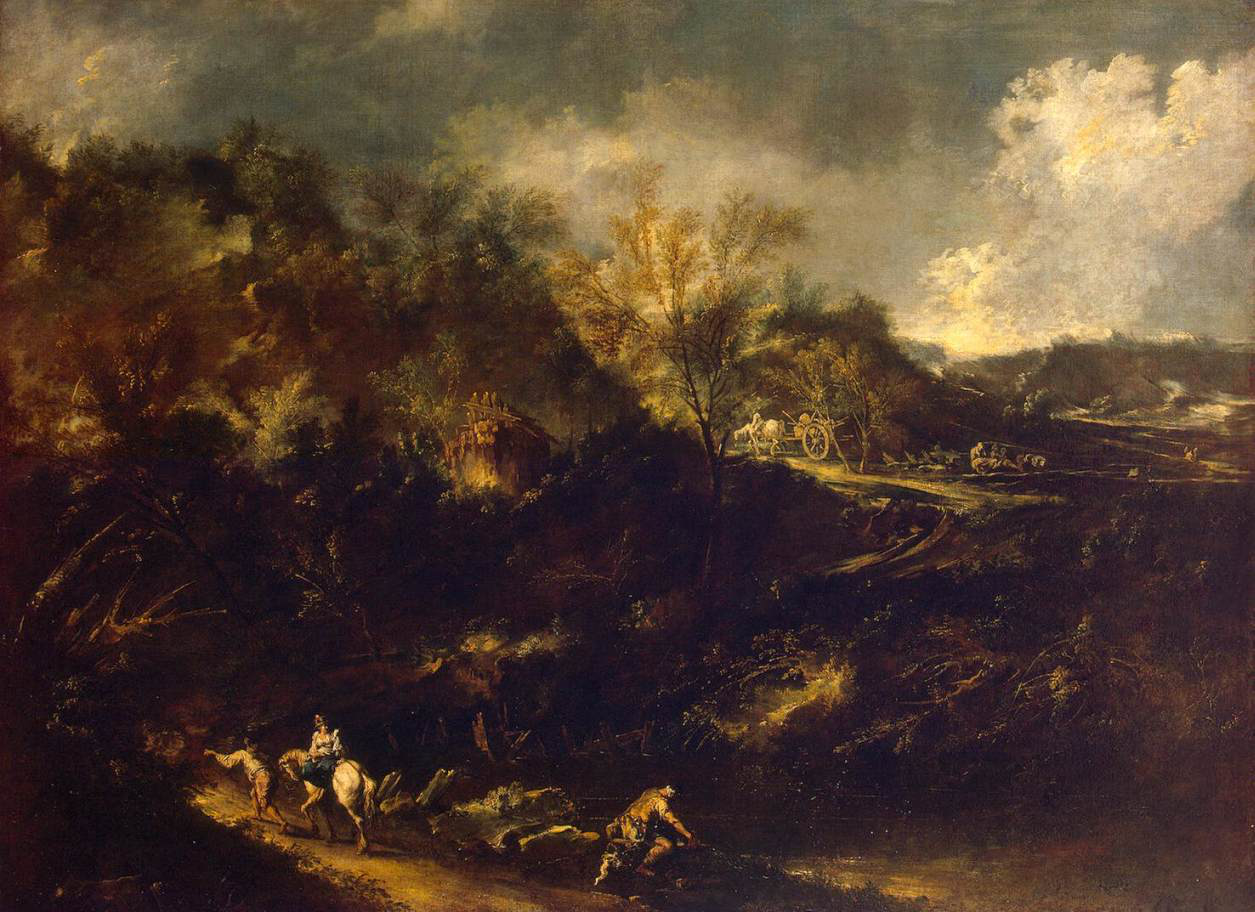

CC:
the painting was executed with the contribution of antonio perruzzini. magnasco, alessandro, mountainous landscape, oil on canvas, 158 x 211 cm, landscape, 1701-1750, italian.

Default:
the countryside and its properties are part of john's message and part of rembrandt's scene - the jordan valley is ready to be filled, the distant hilltop to be lowered.
In CC? False
Custom:
magnasco, alessandro, mountainous landscape, oil on canvas, 158 x 211 cm, landscape, 1701-1750, italian.
In CC? True
-------------------------------------------------------------------------------
Default accuracy: 0.69
Custom accuracy: 0.95


In [13]:
acc_default = 0
acc_custom = 0
for idx in selected:
    img = Image.open(image_paths[idx]).convert("RGB")
    original_cc = dataset[dataset['localpath'] == image_paths[idx]]
    original_cc = sent_tokenize(original_cc[TEXT_COL].values[0])

    custom_ = sentences[numpy.argmax(model_preds[idx])]
    if custom_ in original_cc:
        acc_custom += 1
    default_ = sentences[numpy.argmax(default_preds[idx])]
    if default_ in original_cc:
        acc_default += 1

    if idx in to_display:
        display(img)
        print(f"CC:\n{' '.join(original_cc)}\n")
        print(f"Default:\n{default_}\nIn CC? {default_ in original_cc}")
        print(f"Custom:\n{custom_}\nIn CC? {custom_ in original_cc}")
acc_default /= N
acc_custom /= N

print('-' * 79)
print(f"Default accuracy: {acc_default:.2f}")
print(f"Custom accuracy: {acc_custom:.2f}")